In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data in pandas dataframe

In [2]:
# Load data from MED-R Preindustrial and increased, as before
directory = {'pi' : '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi',
             'incr' : '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr', 
             'curr' : '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/'}

experiments = ['incr', 'pi', 'curr']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
inits = {'pi' : ['b2nq_2022-02-10', 'b2nn_2022-02-14', 'b2ns_2022-02-16'], 
         'incr' : ['b2nr_2022-02-10', 'b2no_2022-02-14', 'b2nt_2022-02-16'], 
         'curr' : ['1_2022-02-10', '1_2022-02-14', '1_2022-02-16']}  # members for incr and pi runs

In [3]:
# Import full lat, lon values
experiment = 'pi'
init = inits['pi'][0]
cont = 'cf'

lat = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc')).latitude.values
lon = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc')).longitude.values
 
# Import time steps, NB there are three sets of time steps depending on the initialisation date
fridays = []
for init in inits['pi']:  # time stamps are the same across experiments pi and icnr
    time = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc')).time.values
    fridays.append((time >= pd.Timestamp(2022,2,18, 0)) & (time <= pd.Timestamp(2022,2,18, 18)))

# Defining box to analyse winds, south england and wales
lat1 = 52.2
lat2 = 50.3
lon1 = -6
lon2 = 1.3

# Create mask
south_england_dict = {'lat': (lat < lat1) & (lat > lat2), 'lon': (lon < lon2) & (lon > lon1)}
llat, llon = np.meshgrid(lon[south_england_dict['lon']], lat[south_england_dict['lat']])

In [4]:

# empty data frame to be filled later
south_df = pd.DataFrame({'lat': [], 
                         'lon' : [],  
                         'experiment' :[],
                         'cfpf' : [], 
                         'member' : [], 
                         'init' : [],
                         'time' : [],
                         'fg10' : []})

# Fill data frame
members = 50
for experiment in experiments:
    for init in inits[experiment]:
        for cont in cfpf:
            
            # import full data set in file
            data = xr.open_dataset(os.path.join(directory[experiment],'EU025/sfc',cont,init+'.nc'))
            south_england = (data.latitude < lat1) & (data.latitude > lat2) & (data.longitude < lon2) & (data.longitude > lon1) 
            friday = (data.time >= pd.Timestamp(2022,2,18, 0)) & (data.time <= pd.Timestamp(2022,2,18, 18))
            data_filtered = data.where(south_england & friday, drop = True)
            
            # store data in data frame with meta data
            if cont == 'cf':  # distinguish between cfpf because members in pf
                length = len(data_filtered.fg10.values.flatten())
                number_timesteps = len(data_filtered.time.values)
                n_lat = llat.shape[0]
                n_lon = llon.shape[1]
                adding = pd.DataFrame({'lat': np.tile(llat.flatten(), number_timesteps), 
                                        'lon' : np.tile(llon.flatten(), number_timesteps), 
                                        'experiment' : np.tile(experiment, length),
                                        'cfpf' : np.tile(cont, length), 
                                        'member' : np.tile(-1, length), 
                                        'init' : np.tile(init, length), 
                                        'time': np.repeat(data_filtered.time.values.flatten(), n_lat*n_lon), 
                                        'fg10' : data_filtered.fg10.values.flatten()})
                south_df = pd.merge(south_df, adding,
                                    how = 'outer')
            
            elif cont == 'pf': 
                for member in range(members):
                    n_lat = llat.shape[0]
                    n_lon = llon.shape[1]
                    adding = pd.DataFrame({'lat': np.tile(llat.flatten(), number_timesteps), 
                                            'lon' : np.tile(llon.flatten(), number_timesteps), 
                                            'experiment' : np.tile(experiment, length),
                                            'cfpf' : np.tile(cont, length), 
                                            'member' : np.tile(member, length), 
                                            'init' : np.tile(init, length), 
                                            'time': np.repeat(data_filtered.time.values.flatten(), n_lat*n_lon), 
                                            'fg10' : data_filtered.fg10.values[:,member,:,:].flatten()})
                    south_df = pd.merge(south_df, adding,
                                        how = 'outer')


In [5]:
south_df.head()

,lat,lon,experiment,cfpf,member,init,time,fg10
0,-5.75,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,10.980364
1,-5.50,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,10.266060
2,-5.25,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,9.034861
3,-5.00,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,7.949120
4,-4.75,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18,7.317068


# Cumulative wind gusts and wind gust histograms

In [6]:
# maximum in time for each grid box
max_time = south_df.groupby(['lat', 'lon', 'init', 'member']).max() # inits are different for pi and incr as well
max_time_mean_latlon = max_time.groupby(['experiment','init', 'member']).mean(numeric_only = True)

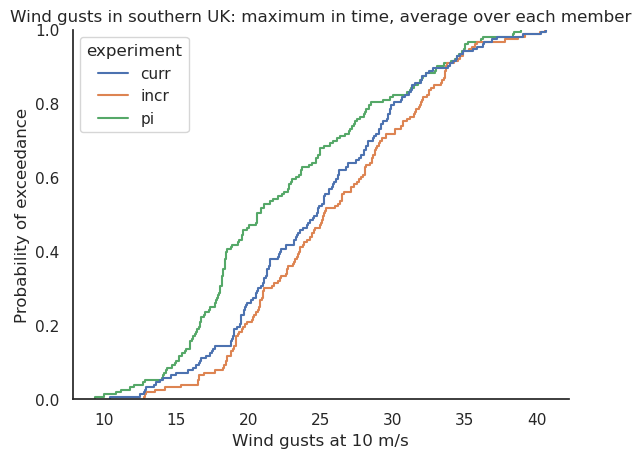

In [7]:
# plot 
sns.ecdfplot(max_time_mean_latlon, x = 'fg10', hue = 'experiment')
plt.xlabel('Wind gusts at 10 m/s')
plt.ylabel('Probability of exceedance')
sns.despine()
plt.title('Wind gusts in southern UK: maximum in time, average over each member')

plt.savefig('figures/03_averaged_cumulative_wind_gusts.pdf')
plt.savefig('figures/03_averaged_cumulative_wind_gusts.png')

Text(0.5, 1.0, 'Wind gusts in southern UK on Friday, 18th Feb')

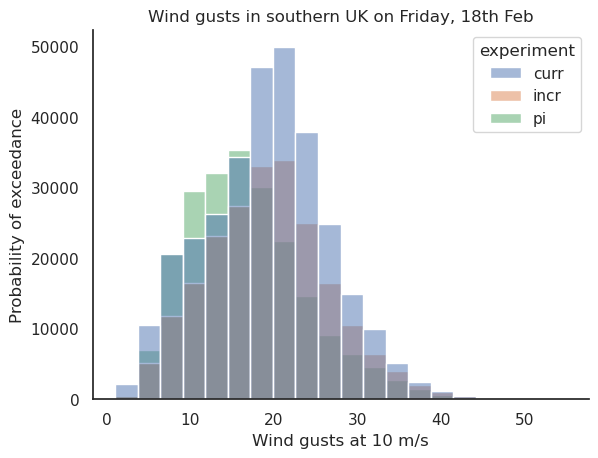

In [8]:
# plot 
south_df['experiment'] = pd.Categorical(south_df['experiment'], ['curr','incr','pi'])
sns.histplot(south_df, x = 'fg10', hue = 'experiment', bins = 20)
plt.xlabel('Wind gusts at 10 m/s')
plt.ylabel('Probability of exceedance')
sns.despine()
plt.title('Wind gusts in southern UK on Friday, 18th Feb')

# Wind gusts by initialisation date

In [9]:
# Reset index from groupby object to variable 
# https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe

max_time_mean_latlon_ = max_time_mean_latlon.reset_index()
max_time_mean_latlon_ = max_time_mean_latlon_.assign(init_date = max_time_mean_latlon_.init.str[-10:])

In [10]:
weibull_fits = {}

for experiment in experiments:
    for init in inits[experiment]:
        
        weibull_fits[init] = {'x' : [], 'params' : [], 'rv' : []}
        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init]
        shape, loc, shape1 = stats.weibull_min.fit(data.fg10.values, floc = 10)
        rv_fit = stats.weibull_min(shape, loc, shape1)  # frozen pdf
        weibull_fits[init]['rv'] = rv_fit
        weibull_fits[init]['x'] = np.linspace(rv_fit.ppf(0.01), rv_fit.ppf(0.99), 1000)
        weibull_fits[init]['params'] = [shape, loc, shape1]

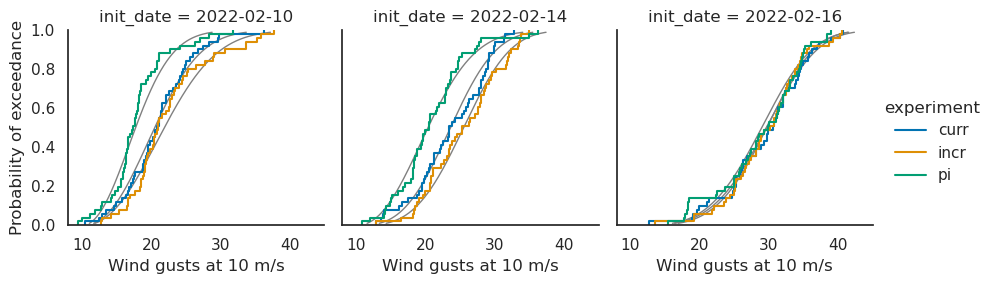

In [11]:
sns.set_palette("colorblind") # could also use palette = sns.color_palette("Paired", 9)
g = sns.FacetGrid(max_time_mean_latlon_, col = 'init_date', hue = 'experiment')
for i, ax in enumerate(g.axes_dict.values()):
    for experiment in experiments:
        init = inits[experiment][i]
        x = weibull_fits[init]['x']
        rv = weibull_fits[init]['rv']
        #ax.plot(x, rv.cdf(x), color = 'grey', lw = 1)
        sns.lineplot(x = x, y= rv.cdf(x), ax = ax, color = 'grey', lw = 1)
g.map(sns.ecdfplot,'fg10')
g.set_axis_labels("Wind gusts at 10 m/s", "Probability of exceedance")
plt.xlim(8, 45)
g.add_legend()
sns.despine()

### Statistical significance

In [12]:
# bootstrap 1,000 times with samples of size 1,000

init_dates = ['2022-02-10', '2022-02-14', '2022-02-16']
bootstraps = 1000
sample_size = 51

for init_date in init_dates:
    print('Initialisation date: ' ,init_date)
    pis = max_time_mean_latlon_[(max_time_mean_latlon_.init_date == init_date) & (max_time_mean_latlon_.experiment == 'pi')].fg10.values
    currs = max_time_mean_latlon_[(max_time_mean_latlon_.init_date == init_date) & (max_time_mean_latlon_.experiment == 'curr')].fg10.values
    incrs = max_time_mean_latlon_[(max_time_mean_latlon_.init_date == init_date) & (max_time_mean_latlon_.experiment == 'incr')].fg10.values

    # lists for p values
    pi_curr = []
    pi_incr = []
    curr_incr = []

    for i in range(bootstraps):
        pi = np.random.choice(pis, size = sample_size)
        curr = np.random.choice(currs, size = sample_size)
        incr = np.random.choice(incrs, size = sample_size)

        pi_curr.append(stats.kstest(pi, curr)[1])
        pi_incr.append(stats.kstest(pi, incr)[1])
        curr_incr.append(stats.kstest(curr, incr)[1])
    print('PI v CURR: p = ', np.mean(pi_curr), ', full sample: p = ', stats.kstest(pis,currs)[1])
    print('PI v INCR: p = ', np.mean(pi_incr), ', full sample: p = ', stats.kstest(pis,incrs)[1])
    print('CURR v INCR: p = ', np.mean(curr_incr), ', full sample: p = ',stats.kstest(currs, incrs)[1])

Initialisation date:  2022-02-10
PI v CURR: p =  0.0025439943059115244 , full sample: p =  4.7712130519607925e-05
PI v INCR: p =  0.00015391165732266154 , full sample: p =  6.848631175063338e-07
CURR v INCR: p =  0.37546101998501286 , full sample: p =  0.8768119540475026
Initialisation date:  2022-02-14
PI v CURR: p =  0.02281506829654121 , full sample: p =  0.0065720003925229765
PI v INCR: p =  0.002070277530333644 , full sample: p =  0.0002962539414562207
CURR v INCR: p =  0.23279631031439818 , full sample: p =  0.4083544056661084
Initialisation date:  2022-02-16
PI v CURR: p =  0.43702928275848035 , full sample: p =  0.8768119540475026
PI v INCR: p =  0.418341497461352 , full sample: p =  0.8768119540475026
CURR v INCR: p =  0.4036937130844865 , full sample: p =  0.9696240652295494


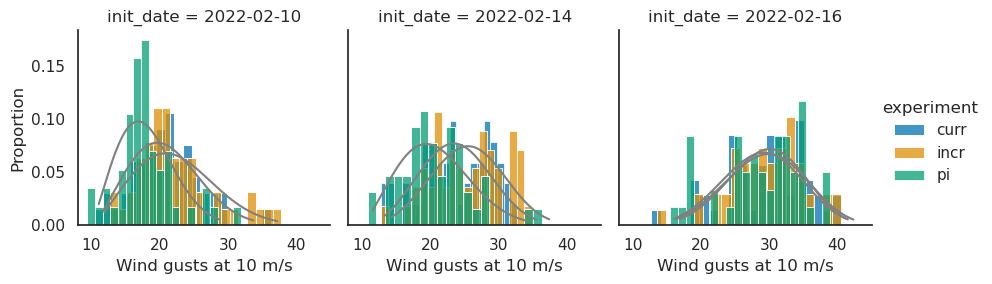

In [13]:
g = sns.FacetGrid(max_time_mean_latlon_, col = 'init_date', hue = 'experiment')
g.map(sns.histplot,'fg10', bins = 20, stat='density')
g.set_axis_labels("Wind gusts at 10 m/s", "Proportion")
for i, ax in enumerate(g.axes_dict.values()):
    for experiment in experiments:
        init = inits[experiment][i]
        x = weibull_fits[init]['x']
        rv = weibull_fits[init]['rv']
        ax.plot(x, rv.pdf(x), color = 'grey')
g.add_legend()
plt.xlim(8, 45)
sns.despine()

# Comparing different distributions

 Weibull (floc = 0,10), generalised logistic, generalised extreme value 

### Cramér von Mises test

In [14]:
weibull_fits0 = {}
weibull_fits10 = {}
gev_fits = {}
gl_fits = {}
bootstraps = 1000
sample_size = 51

args = {'weibull0': [], 'weibull10': [], 'gev': [], 'gl': []}


for experiment in experiments:
    for init in inits[experiment]:
        
        weibull_fits0[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}
        weibull_fits10[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}
        gev_fits[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}
        gl_fits[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}

        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init]
        args['weibull0'] = stats.weibull_min.fit(data.fg10.values, floc = 0)
        args['weibull10'] = stats.weibull_min.fit(data.fg10.values, floc = 10)
        args['gev'] = stats.genextreme.fit(data.fg10.values)
        args['gl'] = stats.genlogistic.fit(data.fg10.values)
        
        for i in range(bootstraps):
            sample = np.random.choice(data.fg10.values, size = sample_size)
            weibull0_ks = stats.cramervonmises(sample, "weibull_min", args = args['weibull0'])
            weibull10_ks = stats.cramervonmises(sample, "weibull_min", args = args['weibull10'])
            gev_ks = stats.cramervonmises(sample, "genextreme", args = args['gev'])
            gl_ks = stats.cramervonmises(sample, "genlogistic", args = args['gl'])

            weibull_fits0[init]['p_boot'].append(weibull0_ks.pvalue)
            weibull_fits10[init]['p_boot'].append(weibull10_ks.pvalue)
            gev_fits[init]['p_boot'].append(gev_ks.pvalue)
            gl_fits[init]['p_boot'].append(gl_ks.pvalue)

In [15]:
for experiment in experiments:
    print(experiment)
    for init in inits[experiment]:
    #     print(init,' Weibull 0 p = ', np.mean(np.array(weibull_fits0[init]['p_boot'])))
        print(init,' Weibull 10 p = ', np.mean(np.array(weibull_fits10[init]['p_boot'])))
        # print(init,' GEV p = ', np.mean(np.array(gev_fits[init]['p_boot'])))
        # print(init,' GL 0 p = ', np.mean(np.array(gl_fits[init]['p_boot'])))

incr
b2nr_2022-02-10  Weibull 10 p =  0.22787943232888283
b2no_2022-02-14  Weibull 10 p =  0.33641134978990994
b2nt_2022-02-16  Weibull 10 p =  0.4147824062530903
pi
b2nq_2022-02-10  Weibull 10 p =  0.1797608165575787
b2nn_2022-02-14  Weibull 10 p =  0.3526112639312215
b2ns_2022-02-16  Weibull 10 p =  0.2954594973504596
curr
1_2022-02-10  Weibull 10 p =  0.37599543022209764
1_2022-02-14  Weibull 10 p =  0.30751210502010506
1_2022-02-16  Weibull 10 p =  0.3513832705806876


### Maximum likelihood 

In [16]:
def NLL(obs, rv): 
    """
    Function to calculate negative likelihood of a fit for a pdf to data

    Inputs
    ------
    obs: array, sample data
    rv: fitted function, scipy frozen distribution object

    Outputs
    -------
    negative log likelihood
    """

    import scipy.stats as stat
    curr = 1
    curr = [(curr:=curr*rv.pdf(v)) for v in obs]
    return -np.log(curr[-1])

In [17]:
loc = 0.1
args = (1,loc,1)
data = np.array([0.2,2,2, 0.1]) # assume for now this is my wind gust data
rv = stats.weibull_min(*args)
print('neg likelihood = ', NLL(data, rv))

neg likelihood =  3.9


In [41]:
def summed_NLL(loc, *args):  # args in order (obs, rv, scale_shape)
    curr = 0  # for the sum 

    for experiment in experiments:
        for init in inits[experiment]:
            rv = args[1](args[2][experiment][init][0],loc, args[2][experiment][init][1])
            data = args[0][max_time_mean_latlon_.init == init].fg10.values
            curr += NLL(data, rv)[-1]
   
    # Calculate neg log likelihood
    return -np.log(curr)

In [44]:
# optimize for one ensemble using fixed location parameter
loc = 10
scale_shape = {}
for experiment in experiments:
    scale_shape[experiment] = {}
    for init in inits[experiment]:
        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init].fg10.values
        x0 = [weibull_fits[init]['params'][0], weibull_fits[init]['params'][2]]
        scale_shape[experiment][init] = sc.optimize.minimize(lambda x : NLL(data, stats.weibull_min(x[0],loc, x[1])), 
                                        x0 = x0, 
                                        method = "Nelder-Mead", 
                                        options = {'maxfev' : 10}).x

# Now minimise the location parameter  for all ensembles using the shape and scale from above
loc = sc.optimize.minimize(summed_NLL, 
                           args = (max_time_mean_latlon_, stats.weibull_min, scale_shape),
                           x0 = 10, 
                           method = "Nelder-Mead", 
                           options = {'maxfev' : 1000}).x

print(loc)

/tmp/user/27529/ipykernel_63547/4236056864.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.log(curr[-1])
